In [1]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

%matplotlib ipympl

In [2]:

def make_detector(dsize, npix, n_rays):
    x = np.linspace(-dsize / 2, dsize / 2, npix)
    x,y = np.meshgrid(x,x)
    
    r = np.array([x, y])
    r = np.moveaxis(r, 0, -1)[..., np.newaxis]
    r = np.tile(r, (1, 1, n_rays))

    return r

In [3]:
n_rays = 1
wavelength = 0.001
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)
deflection = -0.2
a = 0.5
b = 0.5
d = 2*a*deflection
spacing = ((a+b)/abs(d))*wavelength

size = 101
det_shape = (size, size)
pixel_size = 0.001
dsize = det_shape[0] * pixel_size

wo = 0.003
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

In [4]:

components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=0.01,
        wo=wo
    ),
    # comp.Biprism(
    #     z=a,
    #     offset=0.0,
    #     rotation=0.0,
    #     deflection=deflection,
    # ),
    # comp.PerfectLens(
    #     z=a,
    #     f = 0.1,
    #     m = -1,
    # ),
    comp.AccumulatingDetector(
        z=a+b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [5]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

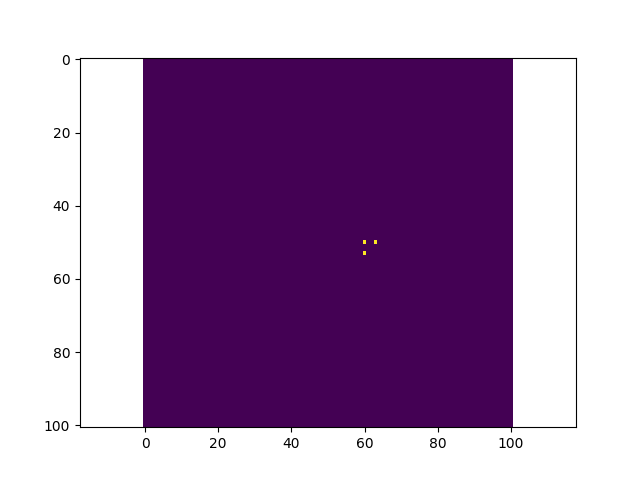

In [6]:
plt.axis('equal')
plt.imshow(np.abs(image)**2/np.max(np.abs(image)**2))
plt.show()

In [7]:
start_rays = rays[0].data[0:4, :].T
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length[0::5]

# Split the array into two parts along the first axis
split_start_rays = np.split(start_rays, n_rays, axis=0)
split_end_rays = np.split(end_rays, n_rays, axis=0)
split_path_length = np.split(path_length, n_rays, axis=0)

# Stack the split arrays along a new axis
rayset0 = np.stack(split_start_rays, axis=-1)
rayset1 = np.stack(split_end_rays, axis=-1)
opd = np.stack(split_path_length, axis=-1)

xStart, yStart = rayset0[0, 0], rayset0[0, 2]
lStart, mStart = rayset0[0, 1], rayset0[0, 3]

xEnd, yEnd = rayset1[0, 0], rayset1[0, 2]
lEnd, mEnd = rayset1[0, 1], rayset1[0, 3]

In [8]:
# AppWindow = QApplication(sys.argv)
# viewer = TemGymWindow(model)
# viewer.show()
# AppWindow.exec()

In [12]:
A, B, C, D = gbd.differential_matrix(rayset1, dPx, dPy, dHx, dHy)

Qinv = gbd.calculate_Qinv(z_r)
Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)

r1m = np.array([rayset1[0, 0], rayset1[0, 2]])
p1m = np.array([rayset1[0, 1], rayset1[0, 3]])

r2 = make_detector(dsize, size, n_rays)
r = r2.copy()

r[..., 0, 0] = r2[..., 0, 0] - xEnd
r[..., 1, 0] = r2[..., 1, 0] - yEnd

print(r.shape)

(101, 101, 2, 1)


In [10]:
field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, r1m, p1m, r2, k, A, B, path_length)

(1,)
(101, 101, 2)
(1,)
(101, 101, 2)
(1, 1)
(1,)


TypeError: Invalid shape (101, 101, 2) for image data

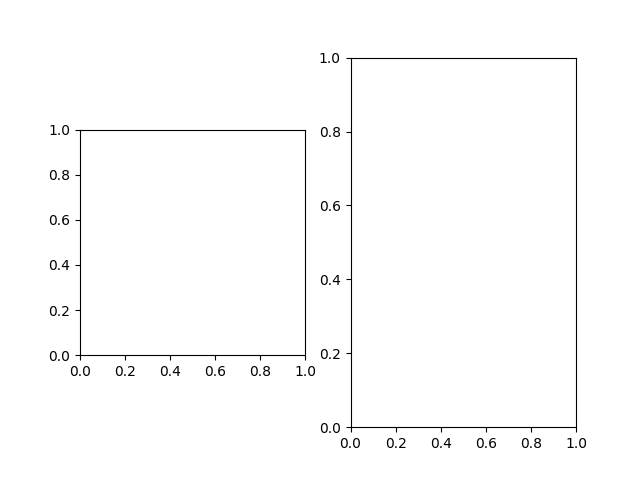

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
# ax1.colorbar()
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
# ax2.colorbar()
fig.suptitle("GBP")

In [ ]:
# z0 = np.zeros((5, n_rays))
# z = np.zeros_like(z0)

# z = z[:, np.newaxis, :]
# zData = z[:, np.newaxis, :]
# xData, yData = rayset1[:, np.newaxis, 0], rayset1[:, np.newaxis, 2]

# n = (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)
# nData = n[:, np.newaxis, :]
# lData, mData = rayset1[:, np.newaxis, 1], rayset1[:, np.newaxis, 3]

# xStart, yStart, zStart = rayset0[:, 0], rayset0[:, 2], 0.0 * zData[:, 0, 0]
# lStart, mStart, nStart = rayset0[:, 1], rayset0[:, 3], 1 / (1 + rayset0[:, 1] ** 2 + rayset0[:, 3] ** 2)

# xEnd, yEnd, zEnd = rayset1[:, 0], rayset1[:, 2], zData[:, 0, 0]
# lEnd, mEnd, nEnd = rayset1[:, 1], rayset1[:, 3], 1 / (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)


In [ ]:
# k = 2 * np.pi / wavelength

# r_ray_start = np.moveaxis(np.asarray([xStart,yStart,zStart]),0,-1)
# k_ray_start = np.moveaxis(np.asarray([lStart,mStart,nStart]),0,-1)
# r_ray = np.moveaxis(np.asarray([xEnd,yEnd,zEnd]),0,-1)
# k_ray = np.moveaxis(np.asarray([lEnd,mEnd,nEnd]),0,-1)

# dcoords = make_detector(dsize, npix, z_prop = 0.0)
# dnorm = np.array([[0., 0., 1.]])


In [ ]:
# field_misaligned = evalmisaligned(r_ray_start, r_ray, k_ray_start, k_ray, opd, npix, dcoords, Amplitude, Qpinv, A, B, k)

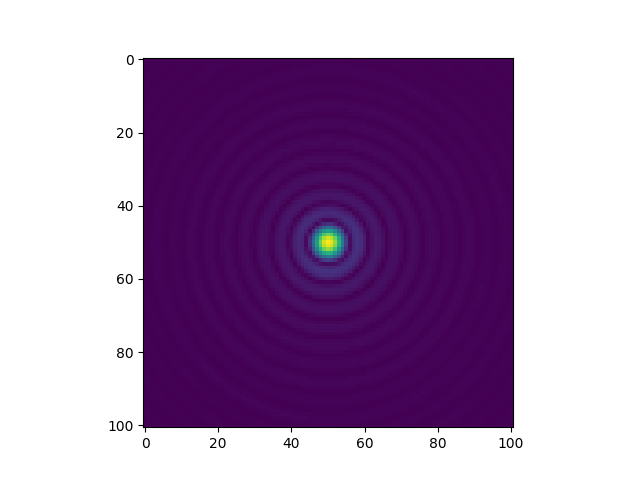

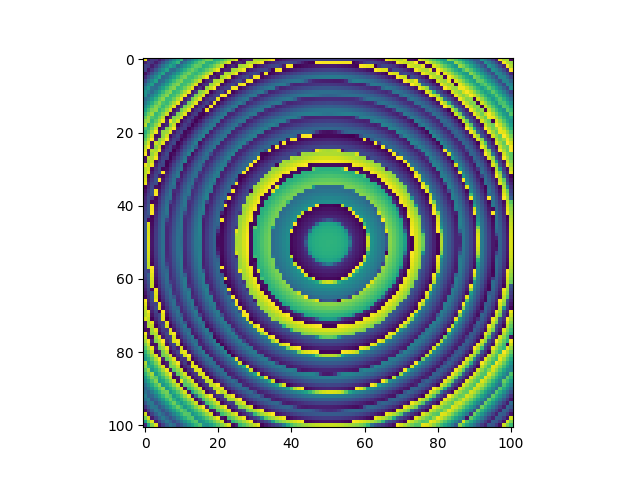